Тестовое задание на позицию Data Science специалист (РБ)  
Т1 Иннотех.  
Батутин А.В.
27.07.2025.

In [ ]:
import os
import warnings
from typing import Tuple, List, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, lag, sum as _sum, unix_timestamp
from pyspark.sql.window import Window
from pyspark.sql.types import *

pd.set_option('display.float_format', '{:.10f}'.format)
pd.options.display.max_columns = 100
warnings.filterwarnings("ignore")
RANDOM_STATE = 313

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# Задача 1

Набор данных из соревнования на Kaggle - https://www.kaggle.com/c/avito-context-ad-clicks.

В файле VisitsStream.tsv содержится информация о посещениях пользователями сайта в хронологическом порядке. Необходимо взять первые 1 000 000 записей **(можно скачать [здесь](https://disk.yandex.com/d/stLP96LSvxBDRw))** из этой таблицы и подсчитать для них топ-10 пользователей (userId) по числу посещений. Количество этих посещений также должно быть отображено в результате. Все этапы - преобразование и выгрузка данных, необходимо произвести с использованием Bash.

In [ ]:

! awk -F',' 'NR > 1 {count[$1]++} END {for (user in count) print user, count[user]}' \
    /content/part-00000-a8316dd9-6e60-4daa-b607-6711f955aa96-c000.csv | \
    sort -k2 -nr | \
    head -n 10


4263912 495
1113291 488
2340557 432
769640 357
1585414 236
4216548 195
3204618 184
4008883 183
4274333 180
1014094 180


Проверим через пандас,что верно подсчитано

In [ ]:
df = pd.read_csv('/content/part-00000-a8316dd9-6e60-4daa-b607-6711f955aa96-c000.csv')
df.groupby('UserID')['ViewDate'].count().sort_values(ascending=False).head(10)

,ViewDate
UserID,
4263912,495
1113291,488
2340557,432
769640,357
1585414,236
4216548,195
3204618,184
4008883,183
4274333,180


# Задача 2

Вы будете работать с данными из комиссии по ценным бумагам и биржам США. С описанием данных можно ознакомиться по следующей [ссылке](https://www.sec.gov/dera/data/edgar-log-file-data-set.html). Здесь порядка терабайта логов с сервера за месяц, разбитых по дням.

Важно заранее создать папку для данных.

Note: запускать необходимо с машины collab

```
mkdir -p /seclog
```

```
apt-get update && apt-get install parallel
```

```
printf %s\\n {01..30} | parallel -k --lb 'wget --user-agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; rv:21.0) Gecko/20100101 Firefox/21.0" http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2017/Qtr2/log201706{}.zip && unzip -p log201706{}.zip log201706{}.csv | tail -n +2 > /seclog/day_{}.csv && rm log201706{}.zip'
```

Чтобы не ждать слишком долго, можно скачать 1-3 первых дня для дальнейшей работы.

Задания

1. Найти 10 пользователей (ip-адресов), которые загрузили больше всего данных за все время используя Spark SQL.
2. Найти 10 пользователей (ip-адресов), у которых самое большое время сессии на сайте (решать можно используя любые инструменты Spark). Сессия на сайте - серия запросов к серверу, сделанных одним пользователем в заданный промежуток времени. Сессия считается завершенной, если в течение 30 минут от пользователя не поступило к серверу ни одного нового запроса. Время сессии - время от запроса, который открыл сессию до последнего запроса в этой сессии.
3. Посчитать суммарное количество пользователей по часам (~гистограма)


Решение
# 1.Найти 10 пользователей (ip-адресов), которые загрузили больше всего данных за все время используя Spark SQL.

In [ ]:
!mkdir -p /seclog


In [ ]:
!apt-get update && apt-get install parallel


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,853 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,152 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,771 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntu

Скачаем 2 дня логов,поменяем значения в {..}


In [ ]:
#Меняем здесь 1-30 на 1-2 день
!printf %s\\n {01..02} | parallel -k --lb 'wget --user-agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; rv:21.0) Gecko/20100101 Firefox/21.0" http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2017/Qtr2/log201706{}.zip && unzip -p log201706{}.zip log201706{}.csv | tail -n +2 > /seclog/day_{}.csv && rm log201706{}.zip'


Выходные данные были обрезаны до нескольких последних строк (5000).
161050K .......... .......... .......... .......... .......... 39% 9.86M 9s
161100K .......... .......... .......... .......... .......... 39%  275M 9s
161150K .......... .......... .......... .......... .......... 39%  232M 9s
161200K .......... .......... .......... .......... .......... 39%  201M 9s
161250K .......... .......... .......... .......... .......... 39% 41.4M 9s
161300K .......... .......... .......... .......... .......... 39%  195M 9s
161350K .......... .......... .......... .......... .......... 39%  237M 9s
161400K .......... .......... .......... .......... .......... 39%  206M 9s
161450K .......... .......... .......... .......... .......... 39%  259M 9s
161500K .......... .......... .......... .......... .......... 39%  241M 9s
161550K .......... .......... .......... .......... .......... 39%  229M 9s
161600K .......... .......... .......... .......... .......... 39%  270M 9s
161650K .......... .

скачаем пакеты Spark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

In [ ]:
import findspark
findspark.init()
spark = SparkSession.builder.appName("SessionDurationAnalysis").config("spark.sql.shuffle.partitions", "200").getOrCreate()

In [ ]:
schema = StructType([
    StructField("ip", StringType(), True),
    StructField("date", StringType(), True),
    StructField("time", StringType(), True),
    StructField("zone", DoubleType(), True),
    StructField("cik", DoubleType(), True),
    StructField("accession", StringType(), True),
    StructField("doc", StringType(), True),
    StructField("code", DoubleType(), True),
    StructField("size", DoubleType(), True),
    StructField("idx", DoubleType(), True),
    StructField("norefer", DoubleType(), True),
    StructField("noagent", DoubleType(), True),
    StructField("find", DoubleType(), True),
    StructField("crawler", DoubleType(), True),
    StructField("browser", StringType(), True)
])

df = spark.read.csv("/seclog/", schema=schema, header=False)

В наличии 53млн наблюдений

In [ ]:
df.count()

53461360

In [ ]:
df.select("date").distinct().show()

+----------+
|      date|
+----------+
|2017-06-01|
|2017-06-02|
+----------+



In [ ]:
df.show(1)

+---------------+----------+--------+----+---------+
|             ip|      date|    time|code|     size|
+---------------+----------+--------+----+---------+
|104.197.198.jbj|2017-06-01|00:00:00| 0.0|1622116.0|
+---------------+----------+--------+----+---------+
only showing top 1 row



Создадим временную таблицу для работы с SparkSQL


In [ ]:
df.createOrReplaceTempView("temp")
top_ips = spark.sql(
    """
  SELECT
    ip,
    ROUND(SUM(size) / 1024 / 1024, 2) AS total_size_mb
  FROM
    temp
  WHERE
    code = 200
  GROUP BY
    ip
  ORDER BY
    total_size_mb DESC
  LIMIT 10
""")

top_ips.show()

+---------------+-------------+
|             ip|total_size_mb|
+---------------+-------------+
| 218.232.78.gfj|    691321.44|
| 208.77.212.aie|    400291.29|
|216.206.127.jbj|    399369.36|
| 24.209.178.hjh|    274261.02|
| 208.77.215.jeh|    244937.42|
|   131.91.7.jdd|     243876.0|
| 162.249.57.hhg|    223368.19|
|   117.91.2.jcf|    167274.55|
| 73.222.244.jad|    140602.56|
| 68.181.148.bji|    100413.98|
+---------------+-------------+



# 2.Найти 10 пользователей (ip-адресов), у которых самое большое время сессии на сайте (решать можно используя любые инструменты Spark). Сессия на сайте - серия запросов к серверу, сделанных одним пользователем в заданный промежуток времени. Сессия считается завершенной, если в течение 30 минут от пользователя не поступило к серверу ни одного нового запроса. Время сессии - время от запроса, который открыл сессию до последнего запроса в этой сессии.

заново загрузим данные,закешируем что бы побыстрее выполнялись однотипные операции

In [ ]:
schema = StructType([
    StructField("ip", StringType(), True),
    StructField("date", StringType(), True),
    StructField("time", StringType(), True),

])
df = spark.read.csv("/seclog/", schema=schema, header=False)
df = df.cache()

Сделаем новую колонку timestamp,которая будет включать в себя и дату и время

In [ ]:
df = df.withColumn(
    "timestamp",
    F.to_timestamp(
        F.concat(F.col("date"), F.lit(" "), F.col("time")),
        "yyyy-MM-dd HH:mm:ss"
    )
)


Сделаем оконную фукнцию с сортировкой для каждого ip,посчитаем разницу во времени между действиями

In [ ]:
df = df.withColumn("timestamp", unix_timestamp(col("timestamp")))
window_ip = Window.partitionBy("ip").orderBy("timestamp")
df = df.withColumn("prev_ts", lag("timestamp").over(window_ip))
df = df.withColumn("time_diff", col("timestamp") - col("prev_ts"))

Создадим булевую колонку,которая будет содержать информацию о том,является ли наблюдение новой сессии основываясь на разнице во времени

In [ ]:

df = df.withColumn("new_session",
                   (col("time_diff").isNull()) | (col("time_diff") > 1800))  # 30 мин = 1800 сек

Проверим на примере,все верно

In [ ]:
df.filter(df.ip=='1.126.48.cfi').show(10)

+------------+----------+--------+----------+----------+---------+-----------+
|          ip|      date|    time| timestamp|   prev_ts|time_diff|new_session|
+------------+----------+--------+----------+----------+---------+-----------+
|1.126.48.cfi|2017-06-01|05:04:52|1496293492|      NULL|     NULL|       true|
|1.126.48.cfi|2017-06-01|05:06:12|1496293572|1496293492|       80|      false|
|1.126.48.cfi|2017-06-01|07:09:35|1496300975|1496293572|     7403|       true|
|1.126.48.cfi|2017-06-01|08:27:52|1496305672|1496300975|     4697|       true|
|1.126.48.cfi|2017-06-01|08:28:10|1496305690|1496305672|       18|      false|
|1.126.48.cfi|2017-06-01|14:21:08|1496326868|1496305690|    21178|       true|
|1.126.48.cfi|2017-06-01|14:41:09|1496328069|1496326868|     1201|      false|
|1.126.48.cfi|2017-06-01|14:41:46|1496328106|1496328069|       37|      false|
|1.126.48.cfi|2017-06-01|14:43:03|1496328183|1496328106|       77|      false|
|1.126.48.cfi|2017-06-01|14:43:07|1496328187|1496328

Определим действия пользователей в рамках именованных цифрой сессий

In [ ]:
# Определение границ сессий
df = df.withColumn("session_id", _sum(col("new_session").cast("int")).over(window_ip))
df.filter(df.ip=='1.126.48.cfi').show(10)

+------------+----------+--------+----------+----------+---------+-----------+----------+
|          ip|      date|    time| timestamp|   prev_ts|time_diff|new_session|session_id|
+------------+----------+--------+----------+----------+---------+-----------+----------+
|1.126.48.cfi|2017-06-01|05:04:52|1496293492|      NULL|     NULL|       true|         1|
|1.126.48.cfi|2017-06-01|05:06:12|1496293572|1496293492|       80|      false|         1|
|1.126.48.cfi|2017-06-01|07:09:35|1496300975|1496293572|     7403|       true|         2|
|1.126.48.cfi|2017-06-01|08:27:52|1496305672|1496300975|     4697|       true|         3|
|1.126.48.cfi|2017-06-01|08:28:10|1496305690|1496305672|       18|      false|         3|
|1.126.48.cfi|2017-06-01|14:21:08|1496326868|1496305690|    21178|       true|         4|
|1.126.48.cfi|2017-06-01|14:41:09|1496328069|1496326868|     1201|      false|         4|
|1.126.48.cfi|2017-06-01|14:41:46|1496328106|1496328069|       37|      false|         4|
|1.126.48.

In [ ]:
# Расчет длительности сессий с группировкой
session_duration = df.groupBy("ip", "session_id").agg(
    (_max("time_diff")).alias("session_duration_sec")
)
session_duration.show(10)

+------------+----------+--------------------+
|          ip|session_id|session_duration_sec|
+------------+----------+--------------------+
| 1.1.169.eff|         1|                 991|
|1.10.198.bdf|         1|                NULL|
|1.10.206.bjh|         1|                NULL|
|1.10.220.cdg|         1|                   3|
|1.125.48.bjg|         1|                NULL|
|1.127.48.eef|         1|                 234|
|1.127.48.eef|         2|                5943|
|1.127.48.eef|         3|                5219|
|1.127.48.eef|         4|                5986|
|1.127.48.eij|         1|                NULL|
+------------+----------+--------------------+
only showing top 10 rows



Для пустых значений проверим верно ли они появляются.
Визуально верно,такие пользователи совершали всего 1 действие

In [ ]:
df.filter(df.ip=='1.46.1.djc').show(10)

+----------+----------+--------+----------+-------+---------+-----------+----------+
|        ip|      date|    time| timestamp|prev_ts|time_diff|new_session|session_id|
+----------+----------+--------+----------+-------+---------+-----------+----------+
|1.46.1.djc|2017-06-01|15:09:43|1496329783|   NULL|     NULL|       true|         1|
+----------+----------+--------+----------+-------+---------+-----------+----------+



In [ ]:
df.filter(df.ip=='104.198.199.hfe').show(10)

+---------------+----------+--------+----------+----------+---------+-----------+----------+
|             ip|      date|    time| timestamp|   prev_ts|time_diff|new_session|session_id|
+---------------+----------+--------+----------+----------+---------+-----------+----------+
|104.198.199.hfe|2017-06-01|19:54:06|1496346846|      NULL|     NULL|       true|         1|
|104.198.199.hfe|2017-06-01|19:54:06|1496346846|1496346846|        0|      false|         1|
+---------------+----------+--------+----------+----------+---------+-----------+----------+



Поиск максимальной сессии для каждого пользователя

In [ ]:
max_sessions = session_duration.groupBy("ip").agg(
    _max("session_duration_sec").alias("max_session_duration_sec")
)
top_users = max_sessions.orderBy(col("max_session_duration_sec").desc()).limit(10)
top_users.show(truncate=False)


+---------------+------------------------+
|ip             |max_session_duration_sec|
+---------------+------------------------+
|99.47.112.bhg  |171711                  |
|184.153.0.gfa  |171431                  |
|162.208.50.gif |170862                  |
|204.102.74.fed |170021                  |
|137.116.199.fjb|169198                  |
|12.130.117.efh |168965                  |
|107.0.85.gjc   |168686                  |
|130.126.255.jcf|168274                  |
|207.66.201.jdd |168256                  |
|88.150.156.hhj |168231                  |
+---------------+------------------------+



171711 секунд это 47 часов.
Это боты скорее всего,так как в описании к данным было сказано что в поле crawler единички это поисковые боты.


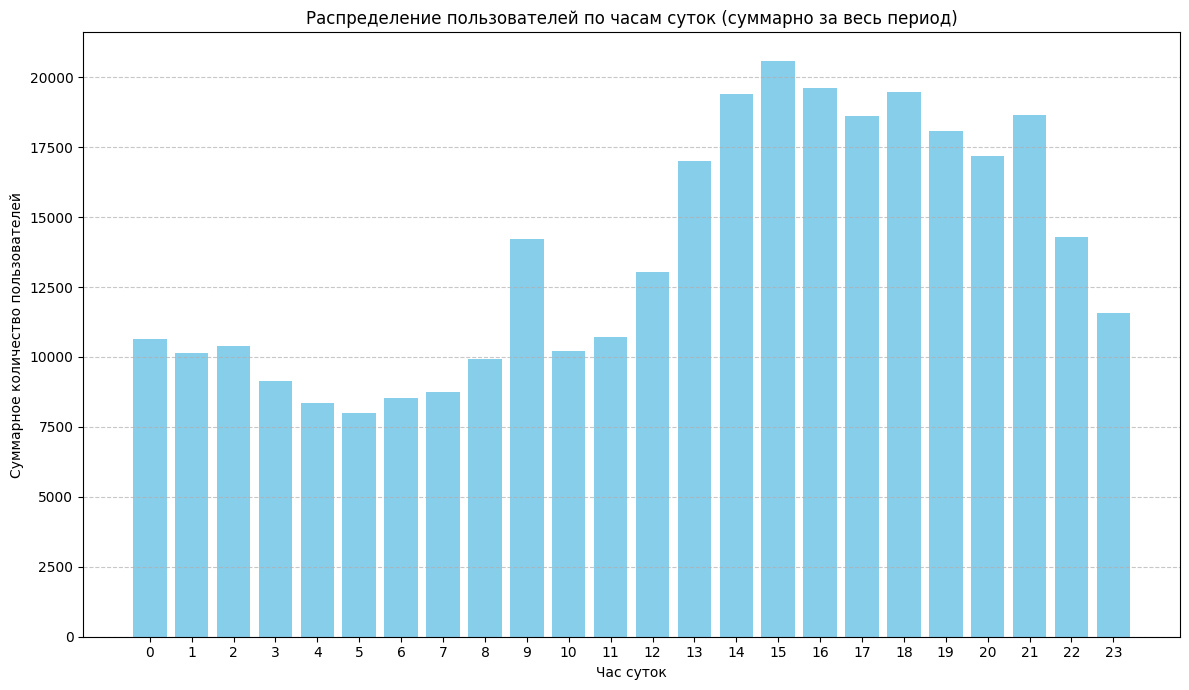

In [ ]:


hourly_users = df.withColumn("timestamp",
                           F.from_unixtime(F.col("timestamp")).cast("timestamp"))

hourly_users = hourly_users.withColumn("hour", F.hour("timestamp"))

hourly_counts = hourly_users.groupBy("hour") \
    .agg(F.countDistinct("ip").alias("total_users")) \
    .orderBy("hour")

pdf = hourly_counts.toPandas()
plt.figure(figsize=(12, 7))
plt.bar(pdf['hour'], pdf['total_users'], color='skyblue')
plt.xlabel('Час суток')
plt.ylabel('Суммарное количество пользователей')
plt.title('Распределение пользователей по часам суток (суммарно за весь период)')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Задача 3 - Теория

Дайте пожалуйста ответы на следующие вопросы:

1. L2-регуляризация применяется для борьбы с вырожденностью. Что подразумевается под вырожденностью и каким образом L2-регуляризация с этим справляется?
2. Назовите возможные критерии расщепления при построении решающих деревьев в задаче классификации, опишите в каких случаях предпочтительней использовать тот или иной критерий (в каких случаях один предпочтительнее остальных).
3. В задаче бинарной классификации 2 объекта имеют метку 1, 3 – метку 0, построили алгоритм с Accuracy < 1, какая максимальная F1-мера может у него быть?
4. Есть два алгоритма кластеризации: k-means, hdbscan. Приведите пример задачи, с которой первый справляется лучше. И задачи, с которой второй справляется лучше.
6. Отличия CatBoost от XGBoost и LightGBM.
7. Когда Extreme Random Trees предпочтительнее Random Forest?

Ответы

#Вопрос 1
L2-регуляризация применяется для борьбы с вырожденностью. Что подразумевается под вырожденностью и каким образом L2-регуляризация с этим справляется?




Вырожденность в машинном обучении проявляется в следующих ситуациях:
- Линейную зависимость признаков(мультиколлинеарность)
- Когда больше признаков, чем объектов.

Это делает обратную матрицу нестабильной или невычислимой,для таких матриц не существует обратных матриц.  
Если обычное аналитическое решение линейной регрессии это   
w = (XᵀX)⁻¹ Xᵀy.   
Тогда механизм борьбы с вырожденностью L2 регуляризации.   
w = (XᵀX + λI)⁻¹ Xᵀy.

Добавление λI(единичной матрицы) гарантирует, что матрица (XᵀX + λI) становится строго положительно определенной и, следовательно, невырожденной, всегда имеющей обратную матрицу.
Это решает проблему строгой вырожденности (когда обратной не существовало).



# Вопрос 2

Назовите возможные критерии расщепления при построении решающих деревьев в задаче классификации, опишите в каких случаях предпочтительней использовать тот или иной критерий (в каких случаях один предпочтительнее остальных).

Основные критерии расщепления узлов:

### 1. **Критерий Джини**  
$$
Gini(t) = 1 - \sum_{i=1}^{C} p_i^2
$$  


где \( p_i \) — доля объектов класса \( i \) в узле \( t \), \( C \) — число классов.  

---

### 2. **Энтропия**  
$$
Entropy(t) = -\sum_{i=1}^{C} p_i \log_2(p_i)
$$  

где \( p_i \) — доля объектов класса \( i \) в узле \( t \), \( C \) — число классов.  

---
### 3. **Критерий хи-квадрат (Chi-Square)**  
Формула:  
$$
\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}
$$  
где \( O_i \) — наблюдаемая частота, \( E_i \) — ожидаемая частота.  

**Когда использовать:**  
- Для категориальных признаков.  
---
|

| **Критерий**             | **Джини (Gini)**                  | **Энтропия (Information Gain)**       | **Хи-квадрат (Chi-Square)**         |
|--------------------------|-----------------------------------|----------------------------------------|-------------------------------------|
| **Скорость**             |  Самый быстрый                  | Средняя                               | Средняя/Низкая                      |
| **Точность разделения**  | Хорошая (~ как Энтропия)          |  Лучше в зонах неопределенности      | Лучше для категориальных данных     |
| **Лучше всего подходит для:** | • Большие данные<br>• Приоритет скорости | • Максимальная точность<br>• Сбалансированные классы | • Категориальные признаки<br>|

# Вопрос 3
В задаче бинарной классификации 2 объекта имеют метку 1, 3 – метку 0, построили алгоритм с Accuracy < 1, какая максимальная F1-мера может у него быть?

Нам нужно добиться , чтобы все объекты положительного класса были предсказаны верно , но допустить одну ошибку в предсказании отрицательного класса ("0").У нас получится следущее.  
TP = 2.        
FN = 0.   
FP = 1.    
TN = 2.

Расчет метрик
precision = tp/(tp+fp) = 2/(2+1) = 0.67

recall = tp/(tp+fn) = 2/(2+0) = 1

f1 = (2*precision*recall)/(precision+recall) = 0.8

Ответ: Максимальный F1 может быть 0.8


# Вопрос 4
Есть два алгоритма кластеризации: k-means, hdbscan. Приведите пример задачи, с которой первый справляется лучше. И задачи, с которой второй справляется лучше.

Задача, где k-means справляется ЛУЧШЕ:
Сегментация клиентов интернет-магазина по среднегодовому доходу (Income) и количеству покупок (Purchase Frequency).
- Исходя из задачи мы сами предполагаем кол-во кластеров,на которое хотим поделить
- Наблюдение внутри кластеров зачастую похожи друг на друга по форме и плотности(интерпретируемость)

Почему HDBSCAN хуже:   
- Он может найти больше или меньше кластеров, чем требуется бизнесу.  
- Алгоритм может пометить часть клиентов как шум без явной необходимости.

Задача, где HDBSCAN справляется ЛУЧШЕ:
Выявление групп аномальной активности  в сетевом трафике на основе множества параметров (число пакетов, порты назначения, размер пакетов, флаги TCP и т.д.).
Почему HDBSCAN лучше:
- Число типов аномалий заранее неизвестно и может меняться.
- Кластеры сложной формы
- Обилие шума:

Почему k-means хуже:
- Фиксированное k: Задание неправильного k (слишком маленького или слишком большого) приведет к объединению разных атак в один кластер или дроблению одной атаки на несколько, либо к включению атак в кластер нормального трафика.
- Сферическое предположение: k-means будет пытаться разделить пространство на сферы, что не соответствует реальной, сложной форме кластеров аномалий.
- Чувствительность к шуму: Все точки должны быть отнесены к какому-то кластеру. k-means попытается "впихнуть" редкие точки аномалий в ближайший большой кластер
- Равный размер/плотность: k-means будет стремиться создать кластеры примерно одинакового размера, что не соответствует природе данных


# Вопрос 5.
Отличия CatBoost от XGBoost и LightGBM.

| **Критерий**       | **XGBoost**               | **LightGBM**              | **CatBoost**                |
|--------------------|---------------------------|---------------------------|-----------------------------|
| **Скорость**       | Медленный                 |  Самый быстрый          | Средний (медленнее LightGBM) |
| **Точность**       | Высокая (аккуратные сплиты) | Средняя (может переобучиться) |  Зачастую точнее других (особенно на категориях) |
| **Категории**      | Требуют One-Hot/обработки | Требуют обработки         |  Работает "из коробки" (главное преимущество!) |
| **Большие данные** | Тяжело масштабируется     |  Оптимизирован под Big Data | Хорошо, но прожорлив к памяти |
| **Переобучение**   | Умеренное (есть регуляризация) | Склонен (особенно на малых данных) |  Устойчив (ordered boosting,симметричные деревья) |
| **Настройка**      | Много гиперпараметров     | Много гиперпараметров     |  Много гиперпараметров , лучшая точность из под коробки|

# Вопрос 6.
Когда Extreme Random Trees предпочтительнее Random Forest?
Extreme Random Trees (ExtraTrees) предпочтительнее Random Forest (RF) в следующих сценариях:

- Требуется максимальная скорость обучения:  
Так как ExtraTrees не ищет оптимальное значение для разделения в узле. Вместо этого он случайно выбирает пороговые значения для каждого признака-кандидата и выбирает лучшее из этих случайных вариантов. Это устраняет дорогостоящий этап вычисления оптимального порога для каждого признака, что является самой затратной частью обучения RF.  
- Высокая размерность признаков :    
В RF, когда на каждом узле рассматривается только случайное подмножество признаков, поиск оптимального разделения по каждому из них может быть очень затратным при большом количестве признаков. У



# Задача 4 - EDA + Feature Selection

Набор данных из соревнования KDD Cup 2009 dataset.  
Описание данных приведено по [ссылке](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=%3D_2&qualities.NumberOfFeatures=gte_10000&qualities.NumberOfInstances=between_10000_100000&id=42758).

Данные уже были преобразованы в формат parquet и находятся по следующей [ссылке](https://disk.yandex.com/d/FcMk1p7izvYL8w).

Задача - провести разведывательный анализ данных и подготовку данных для моделирования (применения метода логистической регрессии). Так же проведите отбор признаков для итоговой модели.

Загрузим данные,посмотрим их форму

In [ ]:
import pandas as pd
df = pd.read_parquet('/content/kdd_dataset.parquet')
df.shape


(50000, 4527)

In [ ]:
df.sample(5)

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,...,Var4479,Var4480,Var4481,Var4482,Var4483,Var4484,Var4485,Var4486,Var4487,Var4488,Var4489,Var4490,Var4491,Var4492,Var4493,Var4494,Var4495,Var4496,Var4497,Var4498,Var4499,Var4500,Var4501,Var4502,Var4503,Var4504,Var4505,Var4506,Var4507,Var4508,Var4509,Var4510,Var4511,Var4512,Var4513,Var4514,Var4515,Var4516,Var4517,Var4518,Var4519,Var4520,Var4521,Var4522,Var4523,Var4524,Var4525,Var4526,Var4527,churn
8123,0,0,0,0,0,0,0.0000000000,0,0,0,0,0.0000000000,0,0,0,0,0,0,2,0,0,10777840.0000000000,0,0,0,0,0,2665344.0000000000,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,13225140.0000000000,0,0,8717580.0000000000,...,0,0,0,0,0,0,0,NaN,0,0,NaN,0,0,0,0,0,0.0000000000,0,0,35,0,0,0,0,0,0,0,0,0,0,8074395.0000000000,0,0,0,0.0000000000,0,0.0000000000,0,0,0,0,0,0,0,21,0,0,0,0,-1
33237,0,0,0,0,0,0,0.0000000000,0,0,0,0,0.0000000000,0,0,0,0,0,0,0,0,0,18810320.0000000000,0,0,0,0,0,2398476.0000000000,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,9710940.0000000000,0,0,4855600.0000000000,...,0,0,0,0,0,0,0,NaN,0,0,NaN,0,0,0,0,0,0.0000000000,0,0,56,0,0,0,0,0,0,0,0,0,0,2538450.0000000000,0,0,0,0.0000000000,0,0.0000000000,0,0,0,0,0,0,0,21,0,0,0,0,-1
35210,0,0,0,0,0,0,0.0000000000,0,0,0,0,0.0000000000,0,0,0,0,0,0,0,0,0,240264.0000000000,0,0,0,0,0,310386.0000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26958.0000000000,0,0,154512.0000000000,...,0,0,0,0,0,0,0,NaN,0,0,NaN,0,0,0,0,0,0.0000000000,0,0,49,0,0,0,0,0,0,0,0,0,0,110169.0000000000,0,0,0,0.0000000000,0,0.0000000000,0,0,0,0,0,0,0,6,0,0,0,0,-1
2357,0,0,0,0,0,0,0.0000000000,0,0,0,0,0.0000000000,0,0,0,0,0,0,0,0,0,20112.0000000000,0,0,0,0,0,2381370.0000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,69144.0000000000,0,0,4503660.0000000000,...,0,0,0,0,0,0,0,NaN,0,0,NaN,0,0,0,0,0,0.0000000000,0,0,21,0,0,0,0,0,0,0,0,0,0,3317499.0000000000,0,0,0,0.0000000000,0,0.0000000000,0,0,0,0,0,0,0,15,0,0,0,0,-1
35377,0,0,0,0,0,0,0.0000000000,0,0,0,0,0.0000000000,0,0,0,0,0,0,0,0,0,12622640.0000000000,0,0,0,0,0,516474.0000000000,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,17410140.0000000000,0,0,1591666.0000000000,...,0,0,0,0,0,0,0,NaN,0,0,NaN,0,0,0,0,0,0.0000000000,0,0,49,0,0,0,0,0,0,0,0,0,0,854892.0000000000,0,0,0,0.0000000000,0,0.0000000000,0,0,0,0,0,0,0,21,0,0,0,0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 4527 entries, Var1 to churn
dtypes: float64(426), int64(4101)
memory usage: 1.7 GB


Приведем таргет в нормальный вид

In [ ]:
df.loc[df['churn']==-1,'churn'] = 0

Проверим дубликаты

In [ ]:
df.loc[df.duplicated()].shape

(0, 4527)

Проверим распределение таргета,имеем сильный дисбаланс классов

In [ ]:
df.churn.value_counts(normalize=True)

,proportion
churn,
0,0.9265600000
1,0.0734400000


Проверим содержимое колонок

In [ ]:

category_features = df.select_dtypes(include=object).columns.to_list()
float_features = df.select_dtypes(include=float).columns.to_list()
int_features = df.select_dtypes(include=int).columns.to_list()
date_features = df.select_dtypes(include='datetime').columns.to_list()

print('len categorycal cols - ',len(category_features))
print('len int cols - ',len(int_features))
print('len float cols - ',len(float_features))
print('len datetime cols - ',len(date_features))

len categorycal cols -  0
len int cols -  4101
len float cols -  426
len datetime cols -  0


У нас 4527 колонок,большая размерность.
Необходимо предварительно отсеять не нужные нам.
Отсекать и проверять будем следующим образом:
- Проверим пропуски
- Проверим корреляцию с таргетом
- Проверим распределение данных в столбцах

In [ ]:
all_count_null = df.isna().sum()

У нас 125 колонок имеющие пропуски > 10%.  
Удалим колонки,так как зачастую востановление больших пропусков не происходит без внесения шума

In [ ]:
all_count_null.loc[all_count_null>len(df)/100*10].shape[0]

125

In [ ]:

cols_to_del = all_count_null.loc[all_count_null>len(df)/100*10].index.to_list()
df = df.drop(cols_to_del,axis=1)

Осталось 4402 колонки
4527->4402

In [ ]:
df.shape

(50000, 4402)

Пропусков не осталось,данные полны

In [ ]:
all_null = df.isna().sum()
all_null.loc[all_null>0]

,0


Идем далее,удалим те колонки,в которых 1 значение содержится в 85% и более случаев.  
Это не сильно информативные признаки

In [ ]:
all_cols = df.columns.drop('churn')
list_to_del = []
for cur_col in all_cols:
    if df[cur_col].value_counts(normalize=True).head(1).values[0]>0.85:#Подсчет самого модного значения в колонке
        list_to_del.append(cur_col)

Такие колонки нам не очень нужны

In [ ]:
df['Var1073'].value_counts()

,count
Var1073,
0,49999
72,1


In [ ]:
df = df.drop(list_to_del,axis=1)

In [ ]:
df.shape

(50000, 486)

Осталось 486 колонок.  
4527->4402->486

Построим линейную корреляцию Спирмана(чтобы аномалии не вносили искажение) для фичей по отношению к таргету.  
Те фичи,которые наимешим образом коррелируют с таргетом удалим

Визуально видно отсутствие выраженной корреляции. Это, вероятно, связано с тем, что на целевую переменную влияет множество нелинейных факторов. Я считаю, что значения ниже 75-го квантиля можно удалить, так как их показатели в сравнении с верхними 25% квантилей слишком низки.

In [ ]:
all_cor = abs(df.corr(method='spearman')['churn']).sort_values()
all_cor.quantile([0.1,0.3,0.5,0.75,0.9])

,churn
0.1000000000,0.0029519612
0.3000000000,0.0098930943
0.5000000000,0.0179698170
0.7500000000,0.0302584174
0.9000000000,0.0400427534


In [ ]:
all_cor = all_cor.loc[all_cor>all_cor.quantile(0.75)]
df = df[all_cor.index]

In [ ]:
df.shape

(50000, 122)

Осталось 122 колонки.  
4527->4402->486->122

Дальше применим интересный подход.  
Побьем каждую колонку на равномерные бины,посмотрим распределение дисперсии   таргета в каждом бине.
В чем идея:чем меньше дисперсия,тем равномернее распределение дисперсии таргета в бинах.Это значит что такие признаки менеее хорошо разделяют таргет по своим значениям.
Подход имеет определенное ограничение,связанное с разнообразием данных в колонке,штук 20 колонок не получилось подсчитать,а для остальных получилось.
Чуть далее я покажу наглядно в чем идея

In [ ]:
#группируем по бинам колонку,считаем дисперсию
dicter = {}
qcut_cols = df.columns
for cur_col in qcut_cols:
    dicter[cur_col] = df.groupby(pd.qcut(df[cur_col],duplicates='drop',q=5))['churn'].mean().std()
dicter = pd.DataFrame(dicter.values(),index=dicter.keys())
dicter.columns = ['std']
dicter = dicter.dropna().sort_values(by='std')

In [ ]:
dicter

,std
Var4420,0.0076904928
Var1817,0.0080929756
Var1530,0.0081416565
Var3234,0.0082182658
Var87,0.0085107454
...,...
Var621,0.0210134536
Var4088,0.0214441193
Var2450,0.0215315602
Var953,0.0222540819


In [ ]:
print('В первом случае видим,что содержание таргета в бинах от 0.05 до 0.08')
display(df.groupby(pd.qcut(df['Var2314'],duplicates='drop',q=5))['churn'].mean())
print('А во втором уже от 0.05 до 0.11 что говорит о том,что вторая колонка чуть лучше разделяет таргет')
display(df.groupby(pd.qcut(df['Var3104'],duplicates='drop',q=5))['churn'].mean())


В первом случае видим,что содержание таргета в бинах от 0.05 до 0.08


,churn
Var2314,
"(-0.001, 45.0]",0.0817391304
"(45.0, 135.0]",0.0637445887
"(135.0, 225.0]",0.0561277034


А во втором уже от 0.05 до 0.11 что говорит о том,что вторая колонка чуть лучше разделяет таргет


,churn
Var3104,
"(-0.001, 56.0]",0.1196328102
"(56.0, 202.666]",0.0785864451
"(202.666, 352.0]",0.0609228913
"(352.0, 485.334]",0.0539107822
"(485.334, 682.666]",0.0533467539


Чем больше дисперсия тем лучше.
Визуально видно что первую треть можно дропнуть

In [ ]:
dicter['std'].quantile([0.1,0.3,0.5,0.7,0.9])

,std
0.1000000000,0.0090517945
0.3000000000,0.0114387813
0.5000000000,0.0131514617
0.7000000000,0.0149832573
0.9000000000,0.0185076575


In [ ]:
to_del = dicter.loc[dicter['std']<dicter['std'].quantile(0.3)].index
df = df.drop(to_del,axis=1)

In [ ]:
df.shape

(50000, 89)

Осталось 89 колонок.  
4527->4402->486->122->89

Проверим дубликаты

In [ ]:
df.loc[df.duplicated()].shape

(4, 89)

Появилось несколько дубликатов ввиду того,что мы поудаляли колонки.  
Удалим для чистоты данных

In [ ]:
df = df.loc[~df.duplicated()]

In [ ]:
global_df = df.copy()

Данные подготовлены.  
Напишем пайплайн обучения модели LogReg,учтем дисбаланс классов,сделаем hold-out валидацию,  заскалируем данные.
Посмотрим метрики.

In [ ]:


def splitter(df: pd.DataFrame, columns: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Разделяет данные на признаки и целевую переменную, а затем на тренировочный и тестовый наборы.
    """
    X = df[columns].drop('churn', axis=1)
    y = df['churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    return X_train, X_test, y_train, y_test

def scaler(X_train: pd.DataFrame, X_test: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    """
    Масштабирует признаки с помощью StandardScaler.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def train_evaluate_model(X_train_scaled: np.ndarray,
                        y_train: pd.Series,
                        X_test_scaled: np.ndarray,
                        y_test: pd.Series) -> None:
    """
    Обучает модель логистической регрессии и выводит метрики качества.
    """
    model = LogisticRegression(class_weight='balanced',random_state=RANDOM_STATE)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-score: {f1:.2f}')
    print(f'ROC AUC: {roc_auc:.2f}')

def run_pipeline(df: pd.DataFrame, columns: List[str]) -> None:
    """
    Запускает полный пайплайн обработки данных и обучения модели.
    """
    X_train, X_test, y_train, y_test = splitter(df, columns)
    X_train_scaled, X_test_scaled = scaler(X_train, X_test)
    train_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test)

Видим не сильно хорошие метрики качества в абсолютном выражении.
Но кажется такая сложна задача как прогноз оттока клиентов с выраженной нелинейностью в поведение клиентов и факторов сложно будет даваться линейной модели.
РокАук 0.65 отличается от случайного 0.5,что дает свидетельства того,что модель поняла определнные важные признаки,которые уже позволяют ей не делать случайные предсказания.
Тоесть фичи которые мы отобрали несут в себе определенную важную информацию

In [ ]:
run_pipeline(df,df.columns)

Precision: 0.11
Recall: 0.65
F1-score: 0.19
ROC AUC: 0.65


Попробуем отбрать фичи Лассо регрессией,что бы улучшить метрики
Возьмем топ20 не зануленых фичей по модулю

In [ ]:

X_train, X_test, y_train, y_test = splitter(df, df.columns)
X_train_scaled, X_test_scaled = scaler(X_train, X_test)
lasso = Lasso(alpha=0.10)
lasso.fit(X_train, y_train)
all_coef = abs(pd.Series(lasso.coef_))
all_coef.index = X_train.columns
all_coef = all_coef.sort_values(ascending=False).head(20).index.to_list()

In [ ]:
run_pipeline(df,all_coef+['churn'])

Precision: 0.10
Recall: 0.63
F1-score: 0.17
ROC AUC: 0.63


Метрики в целом такие же.
Кажется,что модель подойдет как бейслайн, чтобы оценить работу уже более сильных моделей(CatBoost,LGBM)
RocAuc отличается от случайного,что показывает определенные обобщающие способности.
Из 4.5т фичей мы смогли отобрать 88 штук